# Task

Consider windy gridworld environment. Implement simple SARSA and SARSA($\lambda$) learning algorithms. Given 100 episodes:

1. Compare different values of lambda by the means of total number of actions over 100 episodes.
2. Varying $\alpha$ and $\lambda$, train SARSA($\lambda$). Then, stop learning and evaluate the SARSA results several times. Compute average number of performed actions until the end of the episode for each pair of $\alpha$ and $\lambda$. Display plots analogous to ones shown in the lecture. 

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import time

plt.ion()

# Windy GridWorld

In [10]:
class GridWorld(object):
    
    def __init__(self):
        super(GridWorld, self).__init__()
        self.start = 0
        self.goal = 0
        
        # Provide the setting of gridWorld rows and columns
        self.row = 7
        self.col = 10
        self.x_max = self.col - 1
        self.y_max = self.row - 1

        # Declare windy columns and their effect
        self.wind_1 = [3, 4, 5, 8]
        self.wind_2 = [6, 7]
        
        # Provide action list : Up/Down/Left/Right
        self.actions_list = ['N', 'E', 'S', 'W']
      
    # here, cells defined by index
    def cell(self,pos):
        return pos[1] + self.col * pos[0]
    
    def setTerminal(self, startState, goalState):
        # startState and goalState are tuples
        self.start = self.cell(startState)
        self.goal = self.cell(goalState)
        
    def nextState(self, state, action):
        # The "state" parameter is an integer that represents position in grid
        x = state % self.col
        y = (state - x) / self.col

        # Now let's define and interpret actions
        del_x = 0
        del_y = 0
        if action == 'E':
            del_x = 1
        elif action == 'W':
            del_x = -1
        elif action == 'N':
            del_y = -1
        elif action == 'S':
            del_y = 1
        else:
            raise('Invalid action! Actions taken must be in: ', self.actions_list)

        # Now move to new position
        new_x = max(0, min(x + del_x, self.x_max))
        new_y = max(0, min(y + del_y, self.y_max))
        
        # When wind blows to a new state
        if new_x in self.wind_1:
            new_y = max(0, new_y - 1)
        if new_x in self.wind_2:
            new_y = max(0, new_y - 2)
        
        # now let's return these new state values
        return self.cell((new_y,new_x))
    
    def checkTerminal(self, state):
        return state == self.goal
    
    def rewardFunction(self, state_prime):
        # When it reaches terminal state then reward is 0 else all actions should yield -1
        if self.checkTerminal(state_prime):
            return 0
        else:
            return -1

In [11]:
def trajectoryPath(world, traj):
    # Initialize gridworld
    world_map = np.zeros((world.row, world.col))
    for i,state in enumerate(traj):
        x = int(state % world.col)
        y = int((state - x) / world.col)
        world_map[y, x] = i + 1
    print(world_map)
    print("\n")

## SARSA

In [12]:
# function for greedy action
def greedyAct(_q_dict):
    greedy_act = ''
    max_q = -1e10
    for act in world.actions_list:
        if _q_dict[act] > max_q:
            greedy_act = act
            max_q = _q_dict[act]
    return greedy_act

# function for epsilon-greedy action
def epsGreedy(episode, q_dict, epsilon):
    
    m = len(world.actions_list)
    greedy_act = greedyAct(q_dict)

    # strange implementation; today you will see better ones
    p = []
    for act in world.actions_list:
        if act == greedy_act:
            p.append((epsilon * 1. / m) + 1 - epsilon)
        else:
            p.append(epsilon * 1. / m)

    # choose one action given proba
    choice = np.random.choice(world.actions_list, size = 1, p = p)
    return choice[0]

In [30]:
def gridWorld_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1, ep_max=100):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0
    
    ep = 1 # Episode number
    # ep_max = 100 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep <= ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            # what's wrong with it?
            q_table[state][act] += alpha * (reward + gamma * q_table[state_prime][act_prime] - q_table[state][act])
            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        # if ep == (ep_max - 1):
        #     trajectoryPath(world, trajectory)
        
        # Increase the episode counter
        ep += 1
    

    return len(step_ep_list) // ep_max

    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

In [52]:
def gridWorld_lambda_SARSA(world, startState, goalState, alpha=0.1, gamma=1, epsilon=0.1, lam=0.1):
    # Consider input parameters:
    # gamma = 1 as discounted factor
    # default values of alpha and epsilon considered, it will be changed for multiple analysis
    world.setTerminal(startState, goalState)
    
    # Initialize Q(s,a)
    q_table = {}
    for state in range(world.row * world.col):
        q_table[state] = {}
        for act in world.actions_list:
            q_table[state][act] = 0

    e_table = {}
    for state in range(world.row * world.col):
        e_table[state] = {}
        for act in world.actions_list:
            e_table[state][act] = 0
    
    ep = 1 # Episode number
    ep_max = 100 # number of max episodes
    step_ep_list = []
    step = 0

    # strange implementation
    while ep <= ep_max:

        # Initialize state
        state = world.cell(startState)
        trajectory = [state]
        
        # Choose action from state
        act = epsGreedy(ep, q_table[state], epsilon)

        # Processing action
        while not world.checkTerminal(state):
            state_prime = world.nextState(state, act)
            reward = world.rewardFunction(state_prime)
            act_prime = epsGreedy(ep, q_table[state_prime], epsilon)
            # what's wrong with it?

            delta = reward + gamma * q_table[state_prime][act_prime] - q_table[state][act]
            e_table[state][act] += 1

            for s in trajectory:
                for a in world.actions_list:
                    q_table[s][a] += alpha * delta * e_table[s][a]
                    e_table[s][a] *= gamma * lam

            state = state_prime
            act = act_prime

            # Increase Step Counter
            step += 1
            
            # Store the index of the episode of this time step
            step_ep_list.append(ep)
            
            # Update the trajectory
            trajectory.append(state)
        
        # if ep == (ep_max - 1):
        #     trajectoryPath(world, trajectory)

        # Increase the episode counter
        ep += 1
    
    return len(step_ep_list) // ep_max

    start_time = time.time()
    plt.plot(step_ep_list)
    print("Time elapsed is (in Secs): ", time.time() - start_time)
    plt.title('WindyGridWorld_SARSA ', fontsize = 'large')
    plt.xlabel("Number of Steps taken")
    plt.ylabel("Number of Episodes")
    plt.show()

## Task 1

In [61]:
startState = (3, 0)
goalState = (3, 7)

Time elapsed is (in Secs):  21.764870643615723


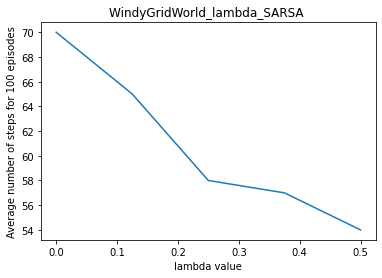

In [65]:
start_time = time.time()

lambda_grid = np.linspace(0, 0.5, 5)
average_num_of_steps = []
for lam in lambda_grid:
    world = GridWorld()
    num = gridWorld_lambda_SARSA(world, startState, goalState, lam=lam, alpha=0.5)
    average_num_of_steps.append(num)

plt.plot(lambda_grid, average_num_of_steps)
print("Time elapsed is (in Secs): ", time.time() - start_time)
plt.title('WindyGridWorld_lambda_SARSA ', fontsize = 'large')
plt.xlabel("lambda value")
plt.ylabel("Average number of steps for 100 episodes")
plt.show()

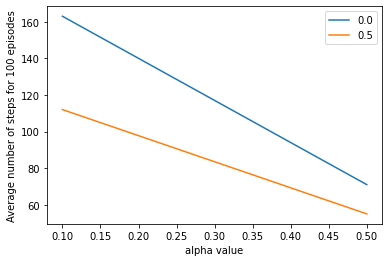

In [74]:
alphas = np.linspace(0.1, 0.5, 2)
lambdas = np.linspace(0, 0.5, 2)

for l in lambdas:
    average_num_of_steps = []
    for a in alphas:
        world = GridWorld()
        num = gridWorld_lambda_SARSA(world, startState, goalState, lam=l, alpha=a)
        average_num_of_steps.append(num)

    plt.plot(alphas, average_num_of_steps, label=str(l))

plt.legend()
plt.xlabel("alpha value")
plt.ylabel("Average number of steps for 100 episodes")
plt.show()

Sorry, did not have aenough time to simulate bigger grid